In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

说明：去噪自编码器，顾名思义就是**去除噪声**！

回顾：
- **中的tensor数据可以和同尺度的numpy数组互相计算的！**
- **array和tensor，都可用用.shape属性查尺寸，用切片取数；但是tensor没有reshape属性！**

In [37]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()  # 原始数据都是numpy！

In [38]:
# 因为使用全连接，故先把每张图片转为一维的！
x_train = x_train.reshape( x_train.shape[0], -1 )
x_test = x_test.reshape( x_test.shape[0], -1 )
# 数值归一化：这里从numpy变成了tensor！
x_train = tf.cast( x_train, tf.float32 ) / 255
x_test = tf.cast( x_test, tf.float32 ) / 255
# # 查看：
x_train.shape, x_test.shape

(TensorShape([60000, 784]), TensorShape([10000, 784]))

### 1. 随机加噪声：

In [39]:
factor = 0.5

In [40]:
# 加随机噪声：
# 注意：加完之后，很用可能又超过[0,1]这个范围了！
x_train_noise = x_train + factor*np.random.normal( size = x_train.shape )
x_test_noise = x_test + factor*np.random.normal( size = x_test.shape )

In [42]:
# 再次归一化：又变成了numpy！
x_train_noise = np.clip( x_train_noise, 0., 1. )  # 小于0归为0，大于1归为1
x_test_noise = np.clip( x_test_noise, 0., 1. )

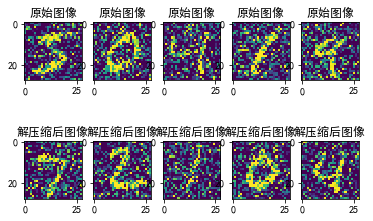

In [44]:
# 画图展示：
n = 5
for x in range(n):
    plt.subplot(2, n, x + 1)
    plt.imshow( x_train_noise[x].reshape(28,28) )
    plt.title('噪声图像')
    plt.subplot(2, 5, x + n + 1)
    plt.imshow( x_test_noise[x].reshape(28,28) )
    plt.title('噪声图像')

### 2. 模型搭建：

说明：自编码模型都不变，唯独最后训练时的**输入数据是加噪声的**，**标签/对比数据是原始的**！

In [46]:
input_size = 784
hidden = 32  # 压缩到长度为32停止
output_size = 784

In [47]:
input = tf.keras.layers.Input( shape = (input_size,) )  
# 压缩encode：2层
en1 = tf.keras.layers.Dense( 64, activation = 'relu', name = 'en1' )(input)
en2 = tf.keras.layers.Dense( hidden, activation = 'relu', name = 'en2' )(en1)
# 解压缩decode：2层
de1 = tf.keras.layers.Dense( 64, activation = 'relu', name = 'de1' )(en2)
de2 = tf.keras.layers.Dense( 784, activation = 'sigmoid', name = 'de2')(de1)  
# 模型创建：
model = tf.keras.Model( inputs = input, outputs = de2 )

In [48]:
# 下面编译和训练都是一样的：
model.compile(
    optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001),  # 优化器实例：这里可以自定义一些参数！！！
    loss = 'mse',  # 类似于L2范数
    metrics = ['acc'] 
)

In [49]:
# 训练：
history = model.fit(
    x_train_noise,  # 换成带噪声的数据！
    x_train,        # “标签”：还是原始好数据！
    epochs = 20,
    batch_size = 256,
    shuffle = True,  
    validation_data = (x_test_noise, x_test)  # 同理！
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0710 - acc: 0.0093 - val_loss: 0.0495 - val_acc: 0.0088
Epoch 2/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0421 - acc: 0.0093 - val_loss: 0.0367 - val_acc: 0.0093
Epoch 3/20
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0347 - acc: 0.0088 - val_loss: 0.0322 - val_acc: 0.0096
Epoch 4/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0315 - acc: 0.0086 - val_loss: 0.0302 - val_acc: 0.0096
Epoch 5/20
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0297 - acc: 0.0098 - val_loss: 0.0285 - val_acc: 0.0111
Epoch 6/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0283 - acc: 0.0099 - val_loss: 0.0273 - val_acc: 0.0102
Epoch 7/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0273 - acc: 0.0107 - val_loss: 0.

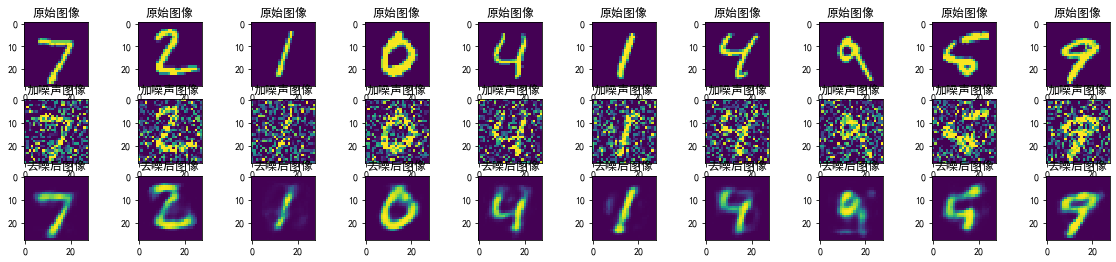

In [60]:
# 预测：
x_test_pred = model.predict( x_test_noise ) 
# 画图：10张垂向对比
plt.figure( figsize = (20,4) )
n = 10
for x in range(n):
    plt.subplot(3, n, x + 1)
    plt.imshow( x_test[x].numpy().reshape(28,28) )
    plt.title('原始图像')
    plt.subplot(3, n, x + n + 1)
    plt.imshow( x_test_noise[x].reshape(28,28) )
    plt.title('加噪声图像')
    plt.subplot(3, n, x + n*2 + 1)
    plt.imshow( x_test_pred[x].reshape(28,28) )
    plt.title('去噪后图像')